# Making Sequence Space Jacobian Matrices in HARK

## Background on SSJs

HARK has functionality for constructing sequence space Jacobian (SSJ) matrices for its various `AgentType` subclass. If you don't know what an SSJ is, see "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models" by Auclert, Bardoczy, Rognlie, and Straub (Ecma 2021); see also our overview notebook [here](../ConsNewKeynesianModel/SSJ_explanation.ipynb).

The very short version is that an SSJ is the matrix of first derivatives of some model output with respect to some model input *across periods*. Suppose we are interested in some scalar $Y_t$-- some outcome of the model-- and how it changes with some model input $x_s$ that can vary across time (both $t$ and $s$ are time subscripts). For example, $Y$ might be average capital holdings, and $x$ might be the interest factor. The SSJ of $Y$ with respect to $x$ is a $T \times T$ matrix denoted $\mathcal{J}^{Y,x}$ for some time horizon $T$. Element $t,s$ of the Jacobian represents the rate at which $Y_t$ changes with a change in $x_s$ if the agents learn this information at $t=0$ when in some long run steady state.

Collectively, all relevant SSJs for a given model represent the dynamic behavior of aggregate outcomes with respect to aggregate inputs *to first order*. In their paper, Auclert et al show that SSJs can be used to quickly compute model impulse responses with incredible accuracy. They also provide an efficient algorithm for calculating SSJs for a wide class of microeconomic models. Econ-ARK has implemented their "fake news" algorithm in HARK, so that SSJs can be automatically computed for *any and all* `AgentType` subclasses (for which this is appropriate) with minimal user effort.

## A First Example

More details will be provided below, but let's start with a very simple example. We'll use `IndShockConsumerType`, the canonical consumption-saving problem with a permanent-transitory income shocks structure (sometimes referred to as the "Friedman buffer stock" income process) and one risk free asset with return factor `Rfree`. In the code cells below, the SSJs for aggregate asset holdings (capital) and aggregate consumption are constructed with respect to the interest factor using the `make_basic_SSJ()` method.

In [1]:
# Import our AgentType subclass and basic tools
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from time import time
import matplotlib.pyplot as plt

# Initialize an infinite horizon AgentType instance
MyType = IndShockConsumerType(cycles=0)

# Make a dictionary of grid specifications
assets_grid_spec = {"min": 0.0, "max": 40.0, "N": 401, "order": 2.5}
consumption_grid_spec = {"min": 0.0, "max": 5.0, "N": 151, "order": 1.5}
my_grid_specs = {"kNrm": assets_grid_spec, "cNrm": consumption_grid_spec}


# Define a simple function for plotting SSJs
def plot_SSJ(jac, S, outcome, shock, t_max=None):
    top = jac.shape[0] + 1 if t_max is None else t_max
    if type(S) is int:
        S = [S]
    for s in S:
        plt.plot(jac[:, s], "-", label="s=" + str(s))
    plt.legend()
    plt.xlabel(r"time $t$")
    plt.ylabel("rate of change of " + outcome)
    plt.title("SSJ for " + outcome + " with respect to " + shock + r" at time $s$")
    plt.tight_layout()
    plt.xlim(-1, top)
    plt.show()

Constructing those SSJs took 11.662 seconds in total.


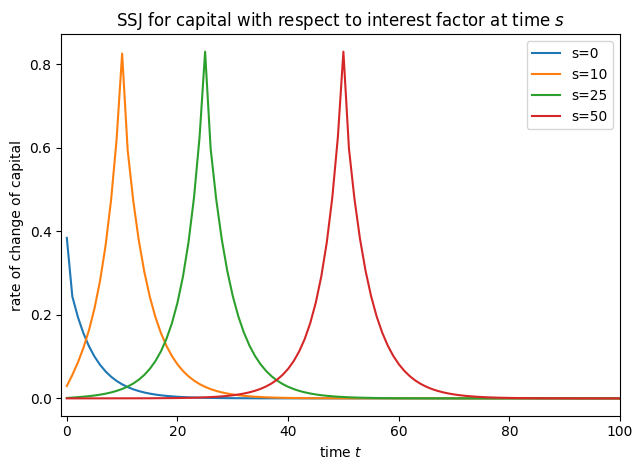

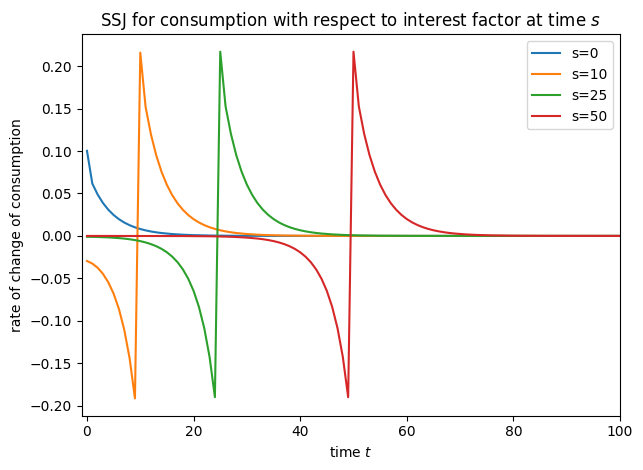

In [2]:
# Compute the SSJs and time it
t0 = time()
SSJ_K_r, SSJ_C_r = MyType.make_basic_SSJ(
    "Rfree",
    ["aNrm", "cNrm"],
    my_grid_specs,
    norm="PermShk",
    offset=True,
)
t1 = time()
print("Constructing those SSJs took {:.3f}".format(t1 - t0) + " seconds in total.")

# Plot some slices of the SSJs
plot_SSJ(SSJ_K_r, [0, 10, 25, 50], "capital", "interest factor", t_max=100)
plot_SSJ(SSJ_C_r, [0, 10, 25, 50], "consumption", "interest factor", t_max=100)

## Basic SSJ Functionality

The `AgentType` class (and thus its many subclasses) has a `make_basic_SSJ()` method. It is "basic" in the sense that it only works for "one period infinite horizon" models, as in the original Auclert et al paper. This just means that the same *kind* of period happens over and over again, with no lifecycle, as in a typical infinite horizon or perpetual youth model. In HARK terms, the `AgentType` instance *must* have `cycles=0` (infinite horizon) and `T_cycle=1` (one period repeated indefinitely), or the method will terminate with an error immediately.

Suppose you have an `AgentType` instance called `ThisType`. When you call `ThisType.make_basic_SSJ()`, you *must* pass the following three arguments:

- `shock` : The name of the variable that the SSJ(s) will be computed with respect to; this is $x$ from above. This doesn't have to be a "shock" in the modeling sense of "a random variable that will realize at some point", but it does have to be a parameter that affects the agent's problem. See below for more.
- `outcomes` : The name (or a list of names) of outcome variables for which SSJs will be constructed; this is $Y$ from above. These must be variables that are realized during model simulation, and the outcome of interest is their population average.
- `grids` : A dictionary of *grid specifications* to be used. The keys of this dictionary are the names of model variables, including both arrival variables and outcomes of interest. The entries are dictionaries with grid information for that variable. If the variable is real-valued, then the dictionary should include a `min`, `max`, and `N`, and the grid will be equispaced by default; additionally specifying an `order` $> 0$ makes a polynomially spaced grid (higher orders have gridpoints more tightly clustered near the bottom). If the variable is discrete, then the dictionary needs only an `N` entry, and the values are assumed to be $0,..,N-1$. The user *must* provide grid specifications for all arrival variables (except one that is normalized with the "Harmenberg trick", see below), as well as for any `outcomes` that are not continuation variables. If a named `outcome` is a continuation variable, (e.g. `aNrm`), then its grid specification is the same as the corresponding arrival variable (e.g. `kNrm`).

You can also pass the following optional arguments, which have defaults in parentheses:

- `eps` (0.0001) : The SSJ constructor uses one-sided first differences for computing derivatives. The `eps` input selects the amount by which to perturb `shock` when doing so.
- `T_max` (300) : The time horizon of the SSJs, and thus the size of the square matrices that are generated. The method assumes that the model returns to the long run steady state at $t=T$ and beyond. See Auclert et al for a discussion of how to select the time horizon.
- `norm` (None) : The name of the model variable to normalize by for "Harmenberg aggregation", if any. For many HARK models, this should be `'PermShk'`, which enables the grid over permanent income to be omitted as an explicit state. See discussion below for caveats.
- `solved` (False) : Whether the agent's long run problem has already been solved (by calling its `solve()` method). Setting this to True is useful to save a little bit of time when computing SSJs for several shocks, as the long run model is the same for all of them.
- `offset` (False) : Whether the model input that is perturbed is "offset in time" and is actually indexed by $t+1$ from HARK's perspective. This usually includes anything that pertains to dynamics that happen at the *start* of a period, before the choice is made.
- `construct` (True) : Whether the agent's `construct` or `update` method should be called after the `shock` is updated. To be safe, this should be left at its default. A (very) small amount of time can be saved if the `shock` variable is a *direct* model input and not used to construct any other model inputs.
- `verbose` (False) : Whether to print information about the method's progress and timing to screen. When working with a new model, we recommend that you set this to `True` so that you can see a bit more about what's happening.

## How Do I Know What the Model Variables Are Called?

To make an SSJ, the user needs to specify what *outcomes* they're interested in and what variable is being perturbed (the "shock"); how are they supposed to know what these variables are called? Under the hood, the SSJ constructor uses a description of the model specified in a *model file* in HARK. To view information about the content of the model file, including descriptions of the various variables that are realized during simulation, just call the `describe_model()` method on your `AgentType` instance. *Any variable* (but not distributions or functions) named in the `SYMBOLS` section can have a grid specified for it and be an `outcome` variable.

We said above that all real-valued arrival variables *must* have a grid specified. What's an "arrival variable"? It's an idiosyncratic variable that's *inbound* into a period, existing at the *very start* of time $t$. For "newborn" agents who were just created, these values are initialized as specified in the `INITIALIZATION AT BIRTH` section. For other agents, arrival variables are "carried over" from the prior period's continuation variables. In the model description, you should see all arrival variables set to *some* value (or drawn from a distribution) in the `INITIALIZATION` section. At the bottom, the `RELABELING / TWIST` section shows the relationships between continuation variables at $t-1$ and arrival variables in $t$ (for non-newborns).

In [3]:
# Get a description of the model
MyType.describe_model()

ConsIndShock: Consumption-saving model with permanent and transitory income shocks and a risk-free asset.

----------------------------------
%%%%%%%%%%%%% SYMBOLS %%%%%%%%%%%%
----------------------------------
kNrm (float)        : beginning of period capital, normalized by p_{t-1}
pLvlPrev (float)    : inbound permanent income level, before growth
yNrm (float)        : normalized labor income
pLvl (float)        : permanent income level
bNrm (float)        : normalized bank balances
mNrm (float)        : normalized market resources
cNrm (float)        : normalized consumption
aNrm (float)        : normalized end-of-period assets
live (bool)         : whether the agent survives
Rfree (param)       : risk free return factor on assets
PermGroFac (param)  : expected permanent income growth factor
LivPrb (param)      : survival probability at end of period
cFunc (func)        : consumption function over market resources
IncShkDstn (dstn)   : joint distribution of permanent and transitory

## What Can Be Used As a Shock Variable?

Learning what can be used as a shock variable for an SSJ (the information that's being perturbed) is a *little* more difficult. It's tempting to look at the model description and assume that anything that's listed as a `param` in the `SYMBOLS` section can be named as the `shock`, but that's an oversimplification. You can choose as the `shock` any parameter that is real-valued, including those that live in a singleton list (say, because they're time-varying). That includes *some* of the parameters listed in the model description, but not necessarily all... and it *also* includes a bunch of other parameters that don't appear in the description anywhere!

In HARK models, some parameters are "direct" in the sense that they are used literally as-is; the intertemporal discount factor `DiscFac` is (usually) simply specified as a real number, and that's that. However, other parameters are "indirect" because they are used to construct *other* objects used by the model. For example, the default income shock process for `IndShockConsumerType` uses parameters called `PermShkStd`, `TranShkStd`, `IncUnemp`, `UnempPrb`, etc. None of those parameters are named in the model description, but they are passed to a *constructor* function to build the contents of `IncShkDstn` at instantiation and whenever the `construct()` method is called. That constructor lives in the `constructors` dictionary attribute of each `AgentType` instance.

A quick way to find the names of the inputs for a constructor function is to use the `get_arg_names` convenience function. To interpret those argument names, you might try using Python's built-in `help` function, which prints an object's docstring (if any). Most constructors used by HARK by default should have descriptive docstrings.

In [4]:
from HARK.core import get_arg_names

print(get_arg_names(MyType.constructors["IncShkDstn"]))

('T_cycle', 'PermShkStd', 'PermShkCount', 'TranShkStd', 'TranShkCount', 'T_retire', 'UnempPrb', 'IncUnemp', 'UnempPrbRet', 'IncUnempRet', 'RNG', 'neutral_measure')


In [5]:
help(MyType.constructors["IncShkDstn"])

Help on function construct_lognormal_income_process_unemployment in module HARK.Calibration.Income.IncomeProcesses:

construct_lognormal_income_process_unemployment(T_cycle, PermShkStd, PermShkCount, TranShkStd, TranShkCount, T_retire, UnempPrb, IncUnemp, UnempPrbRet, IncUnempRet, RNG, neutral_measure=False)
    Generates a list of discrete approximations to the income process for each
    life period, from end of life to beginning of life.  Permanent shocks (:math:`\psi`) are mean
    one lognormally distributed with standard deviation PermShkStd[t] during the
    working life, and degenerate at 1 in the retirement period. Transitory shocks (:math:`\theta`)
    are mean one lognormally distributed with a point mass at IncUnemp with
    probability UnempPrb while working; they are mean one with a point mass at
    IncUnempRet with probability UnempPrbRet.  Retirement occurs
    after t=T_retire periods of working.

    .. math::
        \begin{align*}
        \psi_t &\sim \begin{cases}

For more information about the constructors for your `AgentType` instance, you can invoke its `describe_constructors()` method, optionally passing one or more constructed object names (passing no arguments will display information about all constructors). A checkmark means that the constructed object (or its corresponding requirement) means that it exists; an X means that it has not been constructed and does not exist, and an asterisk means that the input does not exist, but the constructor function has a specified default value for it.

In [6]:
MyType.describe_constructors()

✓ kNrmInitDstn : make_lognormal_kNrm_init_dstn
    ✓ kLogInitMean
    ✓ kLogInitStd
    ✓ kNrmInitCount
    ✓ RNG
✓ pLvlInitDstn : make_lognormal_pLvl_init_dstn
    ✓ pLogInitMean
    ✓ pLogInitStd
    ✓ pLvlInitCount
    ✓ RNG
✓ IncShkDstn : construct_lognormal_income_process_unemployment
    ✓ T_cycle
    ✓ PermShkStd
    ✓ PermShkCount
    ✓ TranShkStd
    ✓ TranShkCount
    ✓ T_retire
    ✓ UnempPrb
    ✓ IncUnemp
    ✓ UnempPrbRet
    ✓ IncUnempRet
    ✓ RNG
    ✓ neutral_measure
✓ PermShkDstn : get_PermShkDstn_from_IncShkDstn
    ✓ IncShkDstn
    ✓ RNG
✓ TranShkDstn : get_TranShkDstn_from_IncShkDstn
    ✓ IncShkDstn
    ✓ RNG
✓ aXtraGrid : make_assets_grid
    ✓ aXtraMin
    ✓ aXtraMax
    ✓ aXtraCount
    ✓ aXtraExtra
    ✓ aXtraNestFac
✓ solution_terminal : make_basic_CRRA_solution_terminal
    ✓ CRRA



Any constructor inputs that are a single `float` or a singleton list of one `float` are eligible to be named as a `shock` variable. Note that in more complex models, some constructor arguments could be constructed by another constructor! In such cases, you might need to look at *another* constructor to find the "basic" or "primitive" parameter that you want to be your `shock`.

To see which model objects have constructors, simply do `list(MyType.constructors.keys())`. If you want to know the names of the functions (and where their source code can be found), look at `MyType.constructors`.

In [7]:
print("Constructed objects are:", list(MyType.constructors.keys()))
for key in MyType.constructors.keys():
    print(key + " : " + str(MyType.constructors[key]))

Constructed objects are: ['kNrmInitDstn', 'pLvlInitDstn', 'IncShkDstn', 'PermShkDstn', 'TranShkDstn', 'aXtraGrid', 'solution_terminal']
kNrmInitDstn : <function make_lognormal_kNrm_init_dstn at 0x000001DA02198360>
pLvlInitDstn : <function make_lognormal_pLvl_init_dstn at 0x000001DA02204540>
IncShkDstn : <function construct_lognormal_income_process_unemployment at 0x000001DA021F6CA0>
PermShkDstn : <function get_PermShkDstn_from_IncShkDstn at 0x000001DA021F72E0>
TranShkDstn : <function get_TranShkDstn_from_IncShkDstn at 0x000001DA021F7380>
aXtraGrid : <function make_assets_grid at 0x000001DA7FBB5A80>
solution_terminal : <function make_basic_CRRA_solution_terminal at 0x000001DA02204EA0>


One quick way to *more or less* get a list of all parameters that can be the `shock` is to look at your `AgentType` subclass' default parameters, which are stored in the attribute `default_["params"]`. Essentially every entry there that is a `float` or singleton list with one `float` can be a `shock` parameter. Of course, not all of them are *interesting* or *relevant* as a `shock`-- we can't imagine what it means economically for the lower bound of the `aNrm` grid (when solving) to change in the future!

Moreover, a very small number of parameters that are otherwise eligible to be named as the `shock` should not be used in this way, because HARK's solution methods assume that these parameters are constant within a person. The primary example of this is `CRRA`, the coefficient of relative risk aversion. We don't think of this as something that can be changed by economic events in the future, but nothing *computationally* prevents a user from asking for SSJs with respect to `CRRA`. However, the output produced will be incorrect, and in some cases the finite horizon model solver might fail during the fake news algorithm.

In [8]:
for key in list(MyType.default_["params"].keys()):
    if key == "constructors":
        continue  # skip this, it's shown above
    print(key + " : " + str(MyType.default_["params"][key]))

PermShkStd : [0.1]
PermShkCount : 7
TranShkStd : [0.1]
TranShkCount : 7
UnempPrb : 0.05
IncUnemp : 0.3
T_retire : 0
UnempPrbRet : 0.005
IncUnempRet : 0.0
kLogInitMean : -12.0
kLogInitStd : 0.0
kNrmInitCount : 15
pLogInitMean : 0.0
pLogInitStd : 0.0
pLvlInitCount : 15
aXtraMin : 0.001
aXtraMax : 20
aXtraNestFac : 3
aXtraCount : 48
aXtraExtra : None
cycles : 1
T_cycle : 1
pseudo_terminal : False
CRRA : 2.0
Rfree : [1.03]
DiscFac : 0.96
LivPrb : [0.98]
PermGroFac : [1.01]
BoroCnstArt : 0.0
vFuncBool : False
CubicBool : False
AgentCount : 10000
T_age : None
PermGroFacAgg : 1.0
NewbornTransShk : False
PerfMITShk : False
neutral_measure : False


## How Does Permanent Income Normalization Work With SSJs?

Most models in HARK normalize all state and control variables by permanent income, because the model is homothetic with respect to it. E.g. agents care about the *ratio* of their market resources to their permanent income, and this is a sufficient statistic for choosing optimal normalized consumption (and thus optimal consumption by multiplying by their permanent income). Because SSJs are computed with respect to aggregate (average) outcomes, merely tracking the distribution of *normalized* state variables wouldn't be enough, because the distribution of permanent income varies by normalized state, and we are interested in the distribution of outcomes in *levels*. We would need to track the joint distribution of (normalized) market resources and permanent income.

Luckily, Karl Harmenberg came up with a way around this computational burden in "Aggregating heterogeneous-agent models with permanent income shocks" (JEDC 2021). In short, he showed that you can use a different probability measure over permanent income shocks, and the resulting distributions of "normalized" state variables will represent a *permanent income weighted* measure. That is, rather than tracking the mass of *people* who have a particular ratio of market resources to permanent income, the distribution instead tracks the mass of *permanent income* at that ratio. Hence aggregating this 1D distribution is sufficient to recover the average level of outcomes like consumption and asset holdings.

Even better, applying the "Harmenberg trick" is trivial: simply multiply probabilities of permanent income realizations by their value, generating a "permanent income neutral" probability measure. HARK uses discretized approximations of continuous distributions, so this is as simple as multiplying the vector of atoms by the probability mass vector when conducting certain operations. Great!

To apply "Harmenberg aggregation" when constructing SSJs, pass to the `norm` argument the name of the permanent income shock, which is `PermShk` in most (all?) HARK models. If you do, then you do *not* need to pass any grid specification for permanent income `pLvl` (or `pLvlPrev`); the constructor will automatically make a dummy grid with one value. However, some caveats are warranted, as the Harmenberg trick is not universally applicable, and using it requires a small compromise with respect to the permanent income of newborn model agents.

Most importantly, it can *only* be used with SSJs when the same *expected* permanent income growth factor applies to all agents (this is `PermGroFac` in most HARK models). For example, with `MarkovConsumerType`, the `PermGroFac` *can* vary with the discrete state; if it does, then Harmenberg aggregation is *not* applicable, and you *must* explicitly track the distribution of permanent income. The *distribution* of permanent income shocks can vary by discrete states, *as long as* the shocks are mean one in all discrete states (e.g. a "low variance" state and a "high variance" state).

An ancillary issue is that the expected permanent income growth factor (the "growth trend") must be interpreted as coming from *macroeconomic* or *secular* growth, not *idiosyncratic* productivity growth. That is, if a model has `PermGroFac = 1.01`, this must represent that (something like) TFP grows at a 1% rate per period, rather than each individual worker's productivity growing at 1% per period because they are personally more experienced. In a model without death, this is a distinction without a difference. With mortality, however, it matters for the productivity of newborn agents who replace decedents: they must enter the model with the same *mean* permanent income as surviving agents, rather than "starting over" from some absolute baseline distribution.

If your model specification requires a "personal productivity" interpretation of `PermGroFac` (and there is death and replacement), then Harmenberg aggregation won't work. Replacing decedents with newborns who have a different mean level of permanent income than surviors would be a violation of the growth trend being *universal*.

## What's Going On Under the Hood?

This is all pretty neat, but this presentation mostly treated `make_basic_SSJ()` as a magic "black box". In this section, we briefly de-mystify the  structures underlying the processing of calculating sequence-space Jacobians.

HARK has a new, developmental simulation structure that is intended to simplify and eventually replace the legacy "handwritten" simulation methods that it has had since its inception. Rather than write somewhat tedious code that extracts the right data for each period, the new simulation system reads a description of the model from a file and automatically handles the simulation process.

A major upside of this system is that it enabled the automated generation of discretized "grid-based" representations of the solution to HARK models. The `solution` attribute of an `AgentType` includes *functions* that map (usually) continuous state variables to (usually) continuous control variables, represented as (sometimes complicated) interpolants. In contrast, many other computational economists construct their "solutions" as arrays of discretized choices on a discretized state space. The new simulation system allows HARK to convert to this other representation, which in turn can be used to construct SSJs for most of our models.

When `make_basic_SSJ()` is called, HARK makes a temporary representation of your agents' model in the `_simulator` attribute, but throws it out just before returning results (see "black box" above). If you want to see some of the internal workings of what's going on, just call `YourAgent.initialize_sym()` and then `YourAgent.make_transition_matrices(...)`, passing a dictionary of grid specifications to the latter, just as you would for `make_basic_SSJ()`.

The first method builds the `_simulator` attribute for your agents; this enables the new simulation system via `symulate()` rather than `simulate()`, and will record Monte Carlo simulation results to the `hystory` dictionary (rather than `history`). The second method builds several attributes onto `_simulator`:

- `trans_arrays`: List of Markov matrices for transitioning from the arrival state space in period t to the arrival state space in t+1. This transition includes death (and replacement).
- `newborn_dstn`: Stochastic vector as a NumPy array, representing the distribution of arrival states for "newborns" who were just initialized.
- `state_grids`: Nested list of tuples representing the arrival state space for each period. Each element corresponds to the discretized arrival state space point with the same index in `trans_arrays` (and `newborn_dstn`). Arrival states are ordered within a tuple in the same order as the model file.
- `outcome_arrays`: List of dictionaries of arrays that cast from the arrival state space to the grid of outcome variables, for each period. Doing `np.dot(state_dstn, outcome_arrays[t][var])` will yield the discretized distribution of that outcome variable.
- `outcome_grids`: List of dictionaries of discretized outcomes in each period. Keys are names of outcome variables, and entries are vectors of discretized values that the outcome variable can take on. Doing `np.dot(np.dot(state_dstn, outcome_arrays[var]), outcome_grids[var])` yields the *average* of that outcome in the population.

You can look at and manipulate these objects to better understand how the discretized transitions and outcomes work when calculating SSJs for your model.